# 1. Setup

## 1.1. Loading packages

In [250]:
import pandas as pd
#!pip install numpy
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import cm
import seaborn as sns
import sklearn
import scipy

import os
import time
import glob
import pickle
from tqdm import trange
from copy import deepcopy

import itertools
import math

# !pip install eeglib
import eeglib
# !pip install git+https://github.com/forrestbao/pyeeg.git
# import pyeeg

# !pip install pymrmre
from pymrmre import mrmr

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

# !pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

# !pip install fooof
# from fooof import FOOOFGroup
# from fooof.bands import Bands
# from fooof.analysis import get_band_peak_fg
# from fooof.plts.spectra import plot_spectrum

#import matplotlib.pyplot as plt

%matplotlib inline

## 1.2. Loading DEAP dataset

In [2]:
# Generating filenames.
filenames = []
participant_count = 22
for i in range(1, participant_count + 1): 
    name = ''
    if i < 10:
        name += '0'
    name += str(i)
    filenames.append(name)
print(*filenames)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22


In [3]:
data, labels = [], []

# Filling data and labels.
for filename in filenames: 
    path = "project_data/s" + filename + ".dat"
    raw_trial = pickle._Unpickler(open(path, 'rb'))
    raw_trial.encoding = 'latin1'
    trial = raw_trial.load()
    data.append(trial['data'])
    labels.append(trial['labels'])

# Each of participant_count (max to 32) participants did 40 trials, resulting in total of 1080 trials
# Data should be reshaped to (trials=participant_count * 40, channes=40, raw_data=8064)
total_channels = 40
trial_count = 40
data = np.array(data)
data = data.flatten()
data = data.reshape(participant_count * trial_count, total_channels, 8064)

# Labels should be reshaped to (trials=participant_count * 40, labels=4)
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(participant_count * trial_count, 4)

In [4]:
print('Data:', data.shape)
print('Labels:', labels.shape)

Data: (880, 40, 8064)
Labels: (880, 4)


# 2. Pre-processing data

## 2.1. Valence and Arousal ratings

In [5]:
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})

In [6]:
df_label_ratings.describe()

,Valence,Arousal
count,880.000000,880.000000
mean,5.218034,5.238898
std,2.093837,1.879631
min,1.000000,1.000000
25%,3.650000,3.895000
50%,5.040000,5.490000
75%,7.040000,6.795000
max,9.000000,9.000000


Let's devide valence and arousal into 2 categories: High and low.

In [7]:
def high_valence(trial):
    return 1 if labels[trial, 0] >= np.median(labels[:,0]) else 0

def high_arousal(trial):
    return 1 if labels[trial, 1] >= np.median(labels[:,1]) else 0

In [8]:
labels_encoded = []
for i in range (len(labels)):
    labels_encoded.append([high_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (participant_count * trial_count, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Valence", "Arousal"])

In [9]:
df_labels.head(5)

,Valence,Arousal
0,1,1
1,1,1
2,1,1
3,0,1
4,1,0


In [10]:
df_valence = df_labels['Valence']
df_arousal = df_labels['Arousal']

Considering Valence and Arousal as High or Low, we can devide these combinations of labels into 4 categories:
1. High Arousal High Valence
2. Low Arousal High Valence
3. High Arousal Low Valence
4. Low Arousal Low Valence

In [11]:
# High Arousal High Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal High Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Low Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Low Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [12]:
print("High Arousal High Valence Count:", len(df_hahv))
print("Low Arousal High Valence Count:", len(df_lahv))
print("High Arousal Low Valence Count:", len(df_halv))
print("Low Arousal Low Valence Count:", len(df_lalv))

High Arousal High Valence Count: 242
Low Arousal High Valence Count: 215
High Arousal Low Valence Count: 200
Low Arousal Low Valence Count: 223


In [13]:
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.12 STD 1.04
Arousal: Mean 6.81 STD 0.84

LAHV:
Valence: Mean 6.67 STD 1.09
Arousal: Mean 3.87 STD 1.09

HALV:
Valence: Mean 3.19 STD 1.23
Arousal: Mean 6.79 STD 0.96

LALV:
Valence: Mean 3.57 STD 1.12
Arousal: Mean 3.47 STD 1.19


{'whiskers': [<matplotlib.lines.Line2D at 0x1c9a86e8e80>,
 'caps': [<matplotlib.lines.Line2D at 0x1c9a86f2580>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c9a86e8b20>,
 'medians': [<matplotlib.lines.Line2D at 0x1c9a86f2c40>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c9a86f2fa0>,
 'means': []}

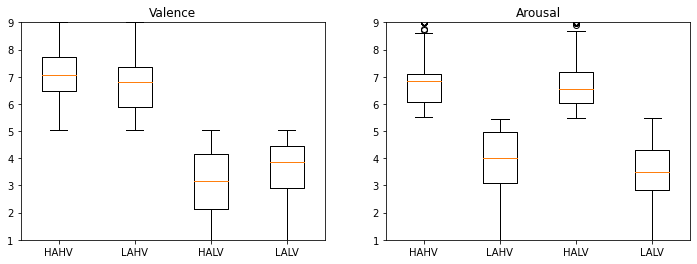

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['Valence'], df_lahv['Valence'], df_halv['Valence'], df_lalv['Valence']], labels=['HAHV','LAHV','HALV', 'LALV'])

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['Arousal'], df_lahv['Arousal'], df_halv['Arousal'], df_lalv['Arousal']], labels=['HAHV','LAHV','HALV', 'LALV'])

Let's encode
- 1 - HAHV
- 2 - LAHV
- 3 - HALV
- 4 - LALV

In [15]:
def get_state(i):
    valence = high_valence(i)
    arousal = high_arousal(i)
    if valence and arousal:
        return 'HAHV'
    elif valence and not arousal:
        return 'LAHV'
    elif not valence and arousal:
        return 'HALV'
    else:
        return 'LALV'

In [16]:
def get_state_code(state):
    if state == 'HAHV':
        return 1
    elif state == 'LAHV':
        return 2
    elif state == 'HALV':
        return 3
    elif state == 'LALV':
        return 4
    else:
        return -1

In [17]:
state_encoded = []
state_name = []
for i in range (len(labels)):
    state = get_state(i)
    state_name.append(state)
    state_encoded.append(get_state_code(state))

In [18]:
df_labels['State_code'] = state_encoded
df_labels['State_name'] = state_name

In [19]:
df_labels.head(5)

,Valence,Arousal,State_code,State_name
0,1,1,1,HAHV
1,1,1,1,HAHV
2,1,1,1,HAHV
3,0,1,3,HALV
4,1,0,2,LAHV


In [20]:
df_labels.describe()

,Valence,Arousal,State_code
count,880.000000,880.000000,880.000000
mean,0.519318,0.502273,2.459091
std,0.499911,0.500279,1.143079
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,1.000000,1.000000,4.000000
max,1.000000,1.000000,4.000000


In [21]:
df_state = df_labels['State_code']

## 2.2. Separating EEg data from peripheral psychological channels

The dataset includes 32 EEG channels and 8 peripheral physiological channels. Let's exclude the latter.

In [22]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [23]:
print(*eeg_channels)

Fp1 AF3 F3 F7 FC5 FC1 C3 T7 CP5 CP1 P3 P7 PO3 O1 Oz Pz Fp2 AF4 Fz F4 F8 FC6 FC2 Cz C4 T8 CP6 CP2 P4 P8 PO4 O2


In [24]:
eeg_data = []
for i in range (len(data)):
    for j in range (len(eeg_channels)):
        eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


In [25]:
peripheral_data = []
for i in range (len(data)):
    for j in range (32,len(data[0])):
        peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(880, 8, 8064)


# 3. Feature extraction

## 3.1. Actually feature extraction

For each trial let's extract corresponding features.
For each of 32 channels the following features can be calculated:
1. Band power for each of 4 frequency ranges (Theta (4, 8), Alpha (8, 12), Beta (12, 30), Gamma (30, 64))
2. Statistical features
    1. Median
    2. Mean
    3. Std
    4. Max
    5. Min
    6.  Kurtosis
3. Hjorth parameters
    1. Activity
    2. Mobility
    3. Complexity
4. Fractal dimension

### 3.1. Let's talk about frequency ranges

Take a look at data sample of len 8064:

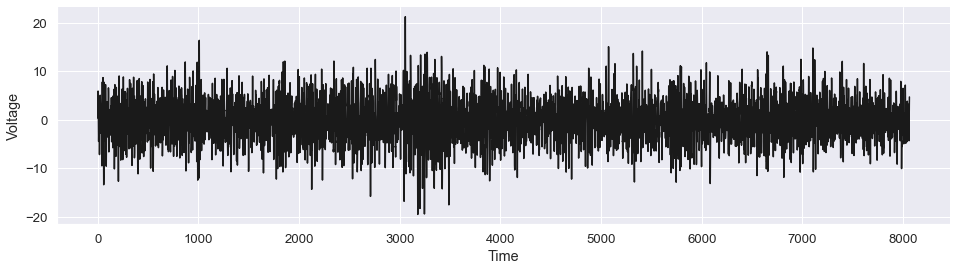

In [26]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

Using data above power spectral density may be calculated:

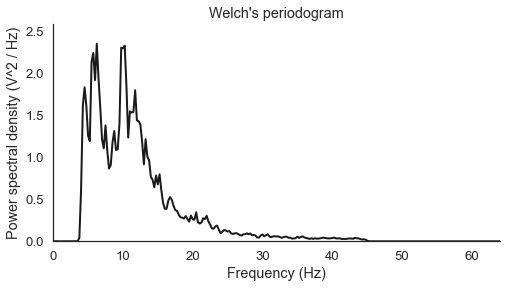

In [27]:
window_length = 4 * sf
freqs, psd = signal.welch(eeg_data[0,31], sf, nperseg=window_length)

sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

Frequency can be devided into 5 diapasons:
- Delta (0.5 - 4.0 Hz, not present in data above)
- Theta (4.0 - 8.0 Hz)
- Alpha (8.0 - 12.0 Hz)
- Beta (12.0 - 30.0 Hz)
- Gamma (30.0 - 64.0 Hz)

In [28]:
def print_frequency_plot(band):
    bd = (0,0)
    if (band == "theta"):
        bd = (4, 8)
    elif (band == "alpha"):
        bd = (8, 12)
    elif (band == "beta"):
        bd = (12, 30)
    elif (band == "gamma"):
        bd = (30, 64)
    lower_bound, upper_bound = bd[0], bd[1]
    idx_theta = np.logical_and(freqs >= lower_bound, freqs <= upper_bound)

    # Plot the power spectral density and fill the theta area
    plt.figure(figsize=(7, 4))
    plt.plot(freqs, psd, lw=2, color='k')
    plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (uV^2 / Hz)')
    plt.xlim([0, 50])
    plt.ylim([0, psd.max() * 1.1]) 
    plt.title("Welch's periodogram: " + band)
    sns.despine()

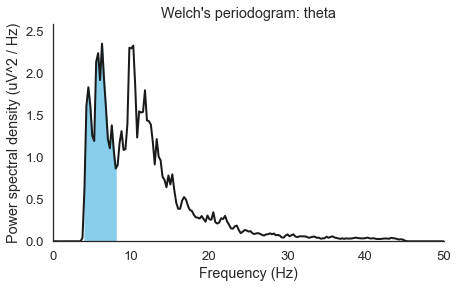

In [29]:
print_frequency_plot('theta')

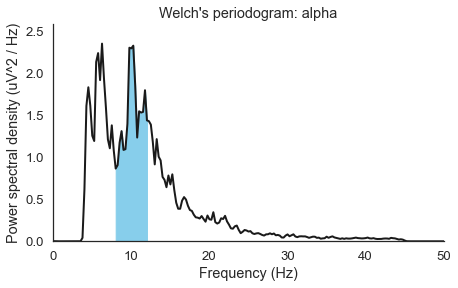

In [30]:
print_frequency_plot('alpha')

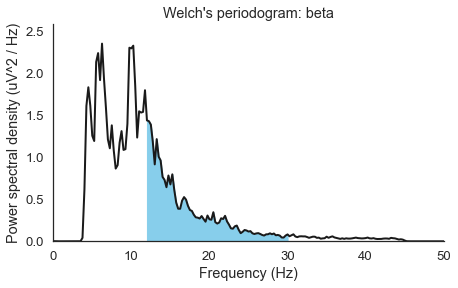

In [31]:
print_frequency_plot('beta')

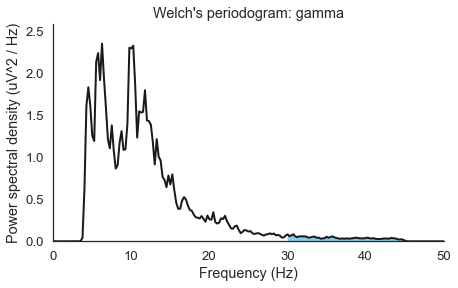

In [32]:
print_frequency_plot('gamma')

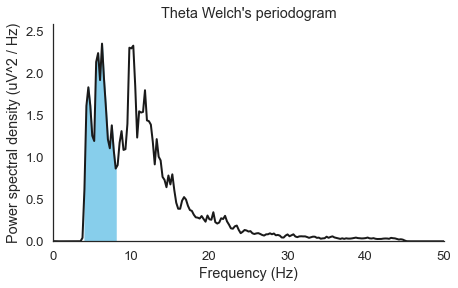

In [33]:
# Define theta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Theta Welch's periodogram")
sns.despine()

In [34]:
# data : raw data
# sf : Sampling frequency
# band : Bounds of band
# window_sec : Length of each window, if None, window_sec = (1 / min(band)) * 2
# relative : If True, return the relative power (= divided by the total power of the signal), else return the absolute power.

def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    lower_bound, upper_bound = band

    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / lower_bound) * sf

    # Compute the modified Welch periodogram.
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution.
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector.
    idx_band = np.logical_and(freqs >= lower_bound, freqs <= upper_bound)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [35]:
# Frequency in DEAP dataset
fs = 128

def get_band_power(trial, channel, band):
    bd = (0,0)
    if (band == "theta"):
        bd = (4, 8)
    elif (band == "alpha"):
        bd = (8, 12)
    elif (band == "beta"):
        bd = (12, 30)
    elif (band == "gamma"):
        bd = (30, 64)
    return bandpower(eeg_data[trial, channel, :], fs, bd)

In [36]:
# Let's choose initial features
band_features = ['Theta','Alpha', 'Beta', 'Gamma'] # 'Theta','Alpha', 'Beta', 'Gamma'
statistical_features = ['Mean', 'Std', 'Kurtosis'] # 'Median', 'Mean', 'Std', 'Max', 'Min', 'Kurtosis'
hjorth_features = ['Activity', 'Mobility', 'Complexity'] # 'Activity', 'Mobility', 'Complexity'
fractal_features = ['Fractal dimension'] # 'Fractal dimension'

features_names = band_features + statistical_features + hjorth_features + fractal_features
feature_count = len(features_names) * 32

In [37]:
features = np.zeros((participant_count * trial_count, feature_count))

In [38]:
for idx in trange(participant_count * trial_count):
    test_features = []
    
    for idy in range(len(eeg_channels)):
        # Band Powers
        test_features.append(get_band_power(idx, idy, "theta"))
        test_features.append(get_band_power(idx, idy, "alpha"))
        test_features.append(get_band_power(idx, idy, "beta"))
        test_features.append(get_band_power(idx, idy, "gamma"))
            
        # Statistical features
        #test_features.append(np.median(eeg_data[idx, idy, :]))
        test_features.append(np.mean(eeg_data[idx, idy, :]))
        test_features.append(np.std(eeg_data[idx, idy, :]))
        # test_features.append(np.max(eeg_data[idx, idy, :]))
        # test_features.append(np.min(eeg_data[idx, idy, :]))
        test_features.append(scipy.stats.kurtosis(eeg_data[idx, idy, :]))

        # Hjorth parameters
        test_features.append(eeglib.features.hjorthActivity(eeg_data[idx, idy, :]))
        test_features.append(eeglib.features.hjorthMobility(eeg_data[idx, idy, :]))
        test_features.append(eeglib.features.hjorthComplexity(eeg_data[idx, idy, :]))

        # Fractal dimension (1 total)
        test_features.append(eeglib.features.PFD(data[idx, idy, :]))
        
            
    test_features = np.asarray(test_features)
    
    features[idx, :] = test_features[:]
    
    

100%|██████████| 880/880 [02:45<00:00,  5.33it/s]


In [39]:
features.shape

(880, 352)

## 3.2. Making additional dataframes

Создадим общий датафрейм

In [40]:
channels_names = []
for i in range(1, 33): 
    name = ''
    if i < 10:
        name += '0'
    name += str(i)
    channels_names.append(name)
print(*channels_names)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32


In [41]:
header = []

for idx in range(len(channels_names)):
    for feature in features_names:
        header.append("{}_{}".format(feature, channels_names[idx]))
        
header

['Theta_01',
 'Alpha_01',
 'Beta_01',
 'Gamma_01',
 'Mean_01',
 'Std_01',
 'Kurtosis_01',
 'Activity_01',
 'Mobility_01',
 'Complexity_01',
 'Fractal dimension_01',
 'Theta_02',
 'Alpha_02',
 'Beta_02',
 'Gamma_02',
 'Mean_02',
 'Std_02',
 'Kurtosis_02',
 'Activity_02',
 'Mobility_02',
 'Complexity_02',
 'Fractal dimension_02',
 'Theta_03',
 'Alpha_03',
 'Beta_03',
 'Gamma_03',
 'Mean_03',
 'Std_03',
 'Kurtosis_03',
 'Activity_03',
 'Mobility_03',
 'Complexity_03',
 'Fractal dimension_03',
 'Theta_04',
 'Alpha_04',
 'Beta_04',
 'Gamma_04',
 'Mean_04',
 'Std_04',
 'Kurtosis_04',
 'Activity_04',
 'Mobility_04',
 'Complexity_04',
 'Fractal dimension_04',
 'Theta_05',
 'Alpha_05',
 'Beta_05',
 'Gamma_05',
 'Mean_05',
 'Std_05',
 'Kurtosis_05',
 'Activity_05',
 'Mobility_05',
 'Complexity_05',
 'Fractal dimension_05',
 'Theta_06',
 'Alpha_06',
 'Beta_06',
 'Gamma_06',
 'Mean_06',
 'Std_06',
 'Kurtosis_06',
 'Activity_06',
 'Mobility_06',
 'Complexity_06',
 'Fractal dimension_06',
 'Theta_07

In [186]:
df_x = pd.DataFrame(data=features, columns=header)

In [252]:
!pip install dataframe_image
import dataframe_image as dfi

In [255]:
dfi.export(df_x.head(5), "df_x.png", max_cols=10)

In [43]:
df_x.head(5)

,Theta_01,Alpha_01,Beta_01,Gamma_01,Mean_01,Std_01,Kurtosis_01,Activity_01,Mobility_01,Complexity_01,...,Alpha_32,Beta_32,Gamma_32,Mean_32,Std_32,Kurtosis_32,Activity_32,Mobility_32,Complexity_32,Fractal dimension_32
0,3.966387,3.362791,5.815234,1.216603,-0.028259,3.889422,0.743994,15.127600,0.620207,1.252645,...,5.369596,6.286556,0.987916,-0.011155,4.376486,0.423327,19.153627,0.550910,1.279431,1.014171
1,5.171664,4.159797,6.395374,1.450174,-0.082712,4.260994,0.710815,18.156071,0.599380,1.278360,...,6.850178,6.795912,1.152470,0.156159,4.882664,0.636155,23.840406,0.524440,1.312275,1.014451
2,4.839268,4.294426,6.721424,1.541999,0.060689,4.317223,0.822480,18.638419,0.612427,1.256156,...,8.209320,8.429777,1.410791,-0.123599,5.181716,0.917153,26.850180,0.547663,1.260934,1.014610
3,4.442888,3.519818,5.380133,1.280744,-0.027773,3.961901,0.869061,15.696661,0.606625,1.282615,...,6.541218,6.753938,1.026295,-0.021971,4.699940,0.515875,22.089439,0.531993,1.286845,1.014051
4,2.698928,2.770151,4.911636,1.076200,-0.062537,3.522773,0.368222,12.409932,0.636997,1.233602,...,5.195625,6.161676,0.946582,0.073402,4.175456,0.552951,17.434434,0.568176,1.236513,1.014226


In [44]:
df_x.describe()

,Theta_01,Alpha_01,Beta_01,Gamma_01,Mean_01,Std_01,Kurtosis_01,Activity_01,Mobility_01,Complexity_01,...,Alpha_32,Beta_32,Gamma_32,Mean_32,Std_32,Kurtosis_32,Activity_32,Mobility_32,Complexity_32,Fractal dimension_32
count,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,...,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,547.699828,182.780787,101.611223,64.360730,0.017145,22.269416,6.704348,960.430091,0.555040,1.451385,...,169.975618,122.210202,78.234919,0.015499,18.592351,6.644478,879.572052,0.528960,1.478235,1.018617
std,1217.588842,397.609258,198.334644,161.216361,0.596332,21.564593,6.998941,2026.699881,0.122132,0.183035,...,476.333660,327.015453,241.881491,0.594446,23.119341,6.766369,2452.977717,0.110149,0.166496,0.001767
min,2.698928,2.770151,4.833550,1.069233,-3.520997,3.522773,0.272780,12.409932,0.298648,1.093989,...,3.617116,5.084168,0.877576,-5.487914,4.085784,0.133386,16.693629,0.316209,1.106087,1.013454
25%,24.093211,14.191465,18.086819,9.012946,-0.089709,9.139276,1.983144,83.526374,0.478303,1.315828,...,9.851048,11.077585,4.285074,-0.075937,7.408875,1.985953,54.891433,0.439337,1.351318,1.017519
50%,58.450614,33.255285,34.722505,20.679781,0.001003,13.240510,4.472306,175.312276,0.567907,1.406131,...,26.317698,19.815355,9.613644,0.001994,11.356563,4.454156,128.971763,0.536035,1.455648,1.018821
75%,366.274753,143.122306,85.835547,48.359529,0.084702,26.486914,9.152136,701.558952,0.639534,1.600350,...,52.167914,40.988955,20.340344,0.087290,17.084196,9.818607,291.869952,0.605760,1.622870,1.019917
max,15524.135098,5627.906982,3528.485435,3213.255538,4.577890,172.900475,69.414999,29894.574324,0.837207,1.923908,...,3966.714864,2454.759737,1794.801694,6.562066,142.243744,75.325747,20233.282779,0.823632,1.847790,1.022099


Channels are devided by their position in the cerebral cortex.

In [45]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["left", "frontal", "right", "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [46]:
left = np.array(["Fp1", "AF3", "F7", "FC5", "T7"])
right = np.array(["Fp2", "AF4", "F8", "FC6", "T8"])
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.
Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


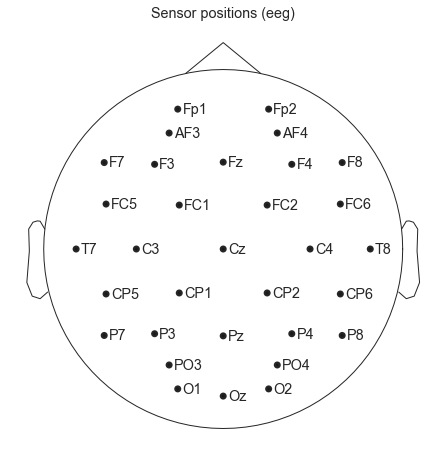

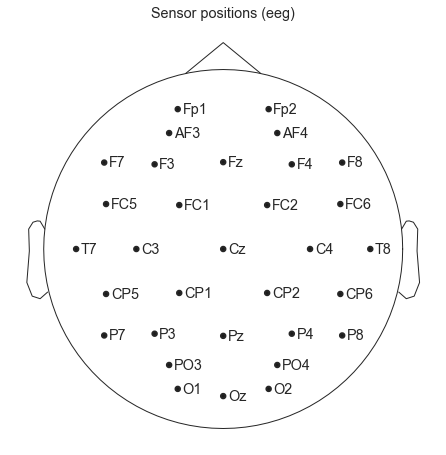

In [47]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
raw_data = mne.io.RawArray(eeg_data[31], info)
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()

In [48]:
def get_data_by_band(band):
    result = []
    for i in range (len(eeg_data)):
        for j in range (len(eeg_data[0])):
            result.append(get_band_power(i, j, band))
    return np.reshape(result, (participant_count * trial_count, len(eeg_channels)))

In [49]:
df_theta = pd.DataFrame(data = get_data_by_band('theta'), columns=eeg_channels)
df_alpha = pd.DataFrame(data = get_data_by_band('alpha'), columns=eeg_channels)
df_beta = pd.DataFrame(data = get_data_by_band('beta'), columns=eeg_channels)
df_gamma =  pd.DataFrame(data = get_data_by_band('gamma'), columns=eeg_channels)

In [50]:
df_theta.head(5)

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2
0,3.966387,5.102688,5.853005,5.791977,2.900011,2.800868,3.247666,6.294923,2.722879,1.597882,...,5.180005,2.085303,2.697530,5.868487,1.806959,1.623311,7.875428,2.970414,6.766592,5.434120
1,5.171664,7.009709,7.645094,8.140612,3.740674,4.221720,4.530124,10.156586,3.478843,2.101888,...,7.370794,2.518165,3.853129,7.779815,2.086140,2.048768,11.846485,3.443451,10.031310,7.958460
2,4.839268,6.321618,7.312348,8.284604,4.483029,3.744902,4.284358,9.635971,3.711943,1.890259,...,9.049269,2.386166,3.942938,8.851559,2.503685,1.974655,11.283598,3.327840,9.238961,6.864887
3,4.442888,6.709155,7.652379,7.634402,3.889140,3.290292,4.171965,8.716423,4.004765,1.883543,...,10.374473,7.414694,3.498076,8.670711,2.529543,1.736048,10.927690,3.154698,8.802466,6.850906
4,2.698928,3.034321,3.150251,3.633784,1.897310,2.025214,1.798486,3.708862,1.857737,1.447578,...,3.629737,1.993286,1.803010,3.425565,1.496299,1.577524,3.697784,2.261119,3.678479,3.681268


In [51]:
df_theta.describe()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2
count,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,...,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,547.699828,1275.383637,961.474061,2081.240523,946.543725,335.659847,629.689546,384.184590,437.472694,278.676186,...,694.346729,520.276926,569.941908,947.742121,575.489698,375.372215,623.574638,222.104105,810.241713,445.032766
std,1217.588842,3736.181334,3558.843893,5918.701828,2572.974374,714.083236,1774.585233,690.041682,1326.666132,515.088325,...,1782.737328,1493.332128,2229.097482,2639.423665,1793.343586,766.492823,1647.573754,498.711644,1937.328397,1285.492111
min,2.698928,3.034321,3.150251,3.633784,1.897310,2.025214,1.798486,3.708862,1.857737,1.340340,...,3.420568,1.890924,1.713283,2.133474,1.496299,1.577431,3.697784,2.167476,3.678479,3.681268
25%,24.093211,18.601381,22.046306,39.123277,13.872183,14.679788,25.657664,53.064342,17.935262,27.918373,...,36.617343,30.904918,10.982013,25.020595,25.419189,22.901013,25.784262,19.265772,27.492929,18.065682
50%,58.450614,72.755754,73.991298,105.346160,43.000439,66.131967,55.403952,134.362766,50.080690,51.480993,...,82.247246,77.880479,25.499318,90.613223,92.051799,73.741624,78.636675,80.094638,66.291245,59.377992
75%,366.274753,313.477898,196.346622,278.757018,256.012013,306.527528,269.628113,400.012778,205.442985,248.159200,...,232.720256,337.152806,131.159987,437.586473,269.262084,299.824333,271.162456,201.890180,463.254689,137.771412
max,15524.135098,38122.870846,39431.320394,49272.793208,20182.668545,8542.244175,26021.167025,7023.985761,14679.421894,5972.589469,...,18617.218099,16408.471958,24826.365142,28038.714329,19908.437378,7210.746793,17568.065100,5487.311705,17167.017710,12314.030522


In [52]:
df_theta[left].describe()

,Fp1,AF3,F7,FC5,T7
count,880.000000,880.000000,880.000000,880.000000,880.000000
mean,547.699828,1275.383637,2081.240523,946.543725,384.184590
std,1217.588842,3736.181334,5918.701828,2572.974374,690.041682
min,2.698928,3.034321,3.633784,1.897310,3.708862
25%,24.093211,18.601381,39.123277,13.872183,53.064342
50%,58.450614,72.755754,105.346160,43.000439,134.362766
75%,366.274753,313.477898,278.757018,256.012013,400.012778
max,15524.135098,38122.870846,49272.793208,20182.668545,7023.985761


# 4. Feature selection

## 4.1. Feature scaling

For Feature Scaling we should adapt basic StandartScaler

In [53]:
def feature_scaling(train, test):
    sc = StandardScaler()
    train = sc.fit_transform(train)
    test = sc.transform(test)
    return train, test

In [54]:
def scale_data(to_scale):
    sc = StandardScaler()
    return sc.fit_transform(to_scale.reshape(1, -1))

## 4.2. Feature selection

Remake df uses Feature Scaling and PCA for 1) normalizing data and 2) Feature Selection, generating new_df from df_x, with reduced number of features, which are normalized

In [124]:
def remake_df(df_x, components):
    sc = StandardScaler()
    new_x = sc.fit_transform(df_x)
    
    pca = PCA(n_components=components)
    
    principal_components = pca.fit_transform(new_x)
    header = [''] * components
    for i in range(components):
        header[i] = 'pc_' + str(i)
        
    new_df = pd.DataFrame(data = principal_components, columns=header)
    return new_df

# 5. Analysis

## 5.1. Simple. Cross-validation to select classifier

In [55]:
def split_train_test(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
    return x_train, x_test, y_train, y_test

In [ ]:
# Let's try to use different methods - SVC, k-nn and MLP
clf_svm = SVC(kernel = 'linear', random_state = 42, probability=True)
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=1000)

models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('MLP', clf_mlp))

In [57]:
def cross_validate_clf_simple(df_x, df_y, scoring):
    x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)

    names = []
    means = []
    stds = []
    times = []
    max_accuracy = 0

    for name, model in models:
        start_time = time.time()
        
        kfold = model_selection.KFold(n_splits=5)
        cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
        
        times.append(time.time() - start_time)
        means.append(cv_results.mean())
        stds.append(cv_results.std())
        names.append(name)
        max_accuracy = max(max_accuracy, cv_results.mean())

    return names, means, stds, times, max_accuracy

In [58]:
# cross_validate_clf_simple(df_x, df_arousal, 'accuracy')

In [59]:
# cross_validate_clf_simple(df_x, df_valence, 'accuracy')

In [60]:
# cross_validate_clf_simple(df_x, df_state, 'accuracy')

In [61]:
import time
def cross_validate_clf_scaled(df_x, df_y, scoring):
    x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
    
    # Feature scaling
    x_train, x_test = feature_scaling(x_train, x_test)

    names = []
    means = []
    stds = []
    times = []
    max_accuracy = 0

    for name, model in models:
        start_time = time.time()
        
        kfold = model_selection.KFold(n_splits=5)
        cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
        
        times.append(time.time() - start_time)
        means.append(cv_results.mean())
        stds.append(cv_results.std())
        names.append(name)
        max_accuracy = max(max_accuracy, cv_results.mean())

    return names, means, stds, times, max_accuracy

In [62]:
cross_validate_clf_scaled(df_x, df_arousal, 'accuracy')

(['SVM', 'k-NN', 'MLP'],
 [0.5990165224232887, 0.5795043273013375, 0.5714266981379492],
 [0.03480606420924427, 0.04099654665486421, 0.022048919017113172],
 [3.198373317718506, 0.2558562755584717, 10.197373628616333],
 0.5990165224232887)

In [63]:
cross_validate_clf_scaled(df_x, df_valence, 'accuracy')

(['SVM', 'k-NN', 'MLP'],
 [0.6087857330186205, 0.5893259900340939, 0.6104510883818516],
 [0.03552733155514185, 0.04883336248723145, 0.03484988653904526],
 [3.4351491928100586, 0.2196667194366455, 9.660489797592163],
 0.6104510883818516)

In [64]:
cross_validate_clf_scaled(df_x, df_state, 'accuracy')

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


(['SVM', 'k-NN', 'MLP'],
 [0.34086021505376346, 0.36685024914765274, 0.3571466037241018],
 [0.05807659734287172, 0.0418919561855764, 0.03087306252909517],
 [4.008639335632324, 0.22411155700683594, 14.262584447860718],
 0.36685024914765274)

## 5.2. Getting accuracy

In [69]:
def run_clf_cv(df_x, df_y, clf):

    x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  
    x_for_kfold = np.array(x_train)            
    y_for_kfold = np.array(y_train)
    kfold = model_selection.KFold(n_splits=5)

    for i, j in kfold.split(x_for_kfold):
        x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
        y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]
  
    x_train2, x_test2 = feature_scaling(x_train2, x_test2)

    if (clf == "svm"):
        clf_svm.fit(x_train2, y_train2)
        y_predict = clf_svm.predict(x_test2)
    elif (clf == "knn"):
        clf_knn.fit(x_train2, y_train2)
        y_predict = clf_knn.predict(x_test2)
    elif (clf == "mlp"):
        clf_mlp.fit(x_train2, y_train2)
        y_predict = clf_mlp.predict(x_test2)

    return y_test2, y_predict

In [70]:
def get_accuracy(df_x, df_y, clf):
    y_test2, y_predict = run_clf_cv(df_x, df_y, clf)
    return np.round(accuracy_score(y_test2, y_predict) * 100, 2)

In [88]:
def plot_cm(df_x, df_y, clf):
    y_test2, y_predict = run_clf_cv(df_x, df_y, clf)
    cm = confusion_matrix(y_test2, y_predict)
    print(cm)
    cr = classification_report(y_test2, y_predict)
    print(cr)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    
    classes = df_y.unique().tolist()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [82]:
print(get_accuracy(df_x, df_arousal, 'svm'),
        get_accuracy(df_x, df_arousal, 'knn'),
            get_accuracy(df_x, df_arousal, 'mlp'))

64.23 61.79 57.72


In [83]:
print(get_accuracy(df_x, df_valence, 'svm'),
        get_accuracy(df_x, df_valence, 'knn'),
          get_accuracy(df_x, df_valence, 'mlp'))

67.48 66.67 63.41


In [85]:
print(get_accuracy(df_x, df_state, 'svm'),
        get_accuracy(df_x, df_state, 'knn'),
            get_accuracy(df_x, df_state, 'mlp'))

36.59 43.9 40.65


[[35 26]
 [18 44]]
              precision    recall  f1-score   support

           0       0.66      0.57      0.61        61
           1       0.63      0.71      0.67        62

    accuracy                           0.64       123
   macro avg       0.64      0.64      0.64       123
weighted avg       0.64      0.64      0.64       123



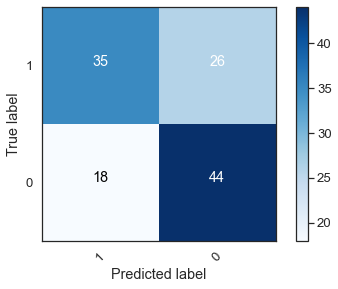

In [89]:
plot_cm(df_x, df_arousal, 'svm')

[[36 17]
 [23 47]]
              precision    recall  f1-score   support

           0       0.61      0.68      0.64        53
           1       0.73      0.67      0.70        70

    accuracy                           0.67       123
   macro avg       0.67      0.68      0.67       123
weighted avg       0.68      0.67      0.68       123



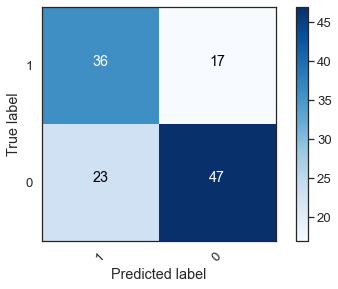

In [90]:
plot_cm(df_x, df_valence, 'svm')

[[21  7  4  4]
 [10 14  5  5]
 [ 4  4 15  3]
 [ 4  8 11  4]]
              precision    recall  f1-score   support

           1       0.54      0.58      0.56        36
           2       0.42      0.41      0.42        34
           3       0.43      0.58      0.49        26
           4       0.25      0.15      0.19        27

    accuracy                           0.44       123
   macro avg       0.41      0.43      0.41       123
weighted avg       0.42      0.44      0.42       123



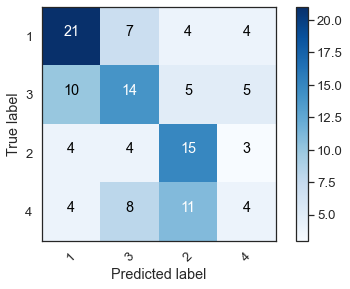

In [91]:
plot_cm(df_x, df_state, 'knn')

In [92]:
def get_results(df_x, df_y):
    max_accuracy = max(get_accuracy(df_x, df_y, 'svm'),
                        get_accuracy(df_x, df_y, 'knn'),
                            get_accuracy(df_x, df_y, 'mlp'))
    return max_accuracy

In [99]:
base_results_arousal = get_results(df_x, df_arousal)

In [100]:
base_results_valence = get_results(df_x, df_valence)

In [101]:
base_results_state = get_results(df_x, df_state)

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


In [256]:
print('Arousal accuracy:', base_results_arousal)
print('Valence accuracy:', base_results_valence)
print('State accuracy:', base_results_state)

Arousal accuracy: 64.23
Valence accuracy: 67.48
State accuracy: 43.9


We aquired decent results (considering scientific papers achieved result ~65 accuracy in Arousal/Valence prediciton)/But we can improve result by implementing PCA

## 5.3. Implementing PCA

Let's find optimal number of components using function from 4.2

In [187]:
def get_pca_results(df_x, df_y):
    
    result = [0] * 2
    for i in trange(2, 75):
        new_df = remake_df(df_x, i)
        result.append(get_results(new_df, df_y))
        
    return result    

In [209]:
def plot_pca_test_results(df_x, df_y, results=None):
    if results is None:
        results = get_pca_results(df_x, df_y)
    plt.figure(figsize=(7, 4))
    x = list(range(2, 75))
    plt.plot(x,results[2 : 75], color= 'k')
    plt.xlabel('Components_count')
    plt.ylabel('Achieved accuracy')
    plt.xlim([0, 80])
    plt.ylim([min(results[2: 75]) * 0.95,max(results[2: 75]) * 1.05])
    plt.title("Implementing PCA")
    sns.despine()

In [198]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [199]:
pca_results_arousal = get_pca_results(df_x, df_arousal)

100%|██████████| 73/73 [02:25<00:00,  1.99s/it]


In [212]:
pca_results_valence = get_pca_results(df_x, df_valence)

100%|██████████| 73/73 [02:21<00:00,  1.93s/it]


In [213]:
pca_results_state = get_pca_results(df_x, df_state)

100%|██████████| 73/73 [02:33<00:00,  2.11s/it]


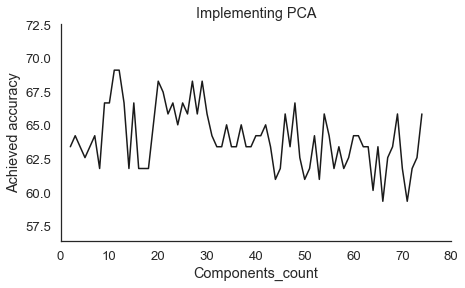

In [210]:
plot_pca_test_results(df_x, df_arousal, pca_results_arousal)

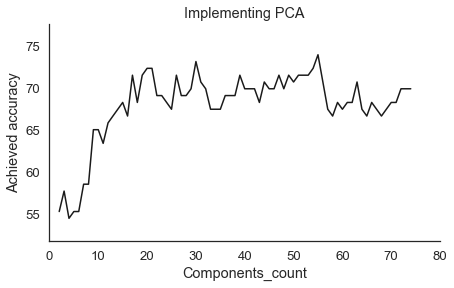

In [214]:
plot_pca_test_results(df_x, df_valence, pca_results_valence)

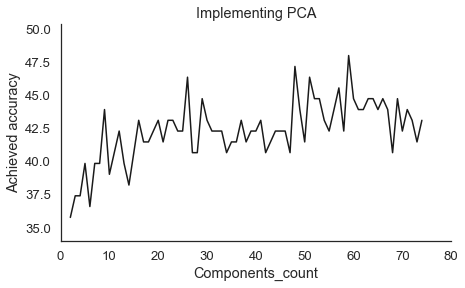

In [215]:
plot_pca_test_results(df_x, df_state, pca_results_state)

In [221]:
def plot_pca_test_helper2(df_x, df_y, results=None, lower_bound=None, upper_bound=None):
    if results is None:
        results = get_pca_results(df_x, df_y)
    plt.figure(figsize=(7, 4))
    if lower_bound is None:
        lower_bound = 10
    if upper_bound is None:
        upper_bound = 40
    plt.plot(range(lower_bound, upper_bound), results[lower_bound:upper_bound], color='k')
    plt.xlabel('Components_count')
    plt.ylabel('Achieved accuracy')
    plt.xlim([lower_bound, upper_bound])
    plt.ylim([min(results[lower_bound:upper_bound]) * 0.95, max(results[lower_bound:upper_bound]) * 1.05])
    plt.title("Implementing PCA")
    sns.despine()

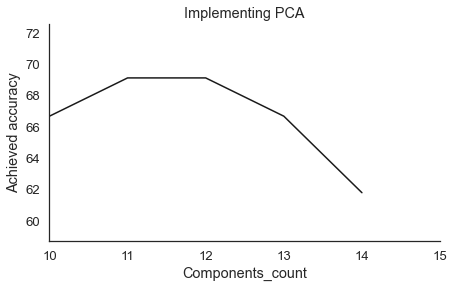

In [222]:
plot_pca_test_helper2(df_x, df_arousal, pca_results_arousal, 10, 15)

Можно взять число компонент = 12

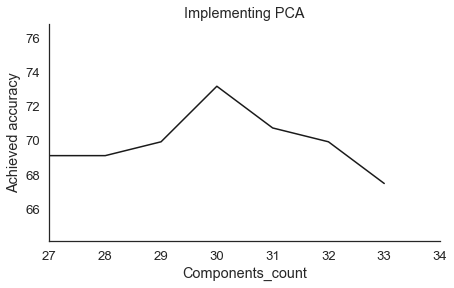

In [223]:
plot_pca_test_helper2(df_x, df_valence, pca_results_valence, 27, 34)

Можно взять число компонент = 30

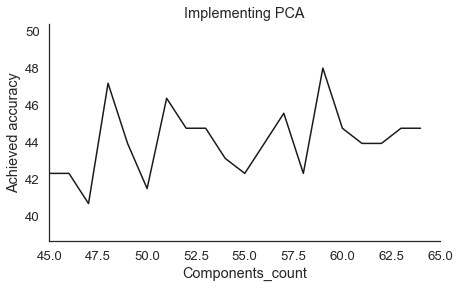

In [224]:
plot_pca_test_helper2(df_x, df_state, pca_results_state, 45, 65)

Можно взять число компонент = 59

New features_counts

In [225]:
optimal_components_arousal = 12
optimal_components_valence = 30
optimal_components_state = 59

In [226]:
def get_optimal_results(df_x, df_y, components=None):
    new_dx = df_x
    if  components:
        new_dx = remake_df(df_x, components)
    max_accuracy = max(get_accuracy(new_dx, df_y, 'svm'),
                        get_accuracy(new_dx, df_y, 'knn'),
                            get_accuracy(new_dx, df_y, 'mlp'))
    return max_accuracy

In [227]:
optimal_results_arousal = get_optimal_results(df_x, df_arousal, optimal_components_arousal)

In [228]:
optimal_results_valence = get_optimal_results(df_x, df_valence, optimal_components_valence)

In [229]:
optimal_results_state = get_optimal_results(df_x, df_state, optimal_components_state)

## 5.4. Results

In [237]:
print('Base Arousal accuracy:', base_results_arousal)
print('Base Valence accuracy:', base_results_valence)
print('Base State accuracy:', base_results_state)

Base Arousal accuracy: 64.23
Base Valence accuracy: 67.48
Base State accuracy: 43.9


In [258]:
print('PCA Arousal accuracy:', optimal_results_arousal, '. Components reduction: ', len(features[0]), ' -> ', optimal_components_arousal)
print('PCA Valence accuracy:', optimal_results_valence, '. Components reduction: ', len(features[0]), ' -> ', optimal_components_valence)
print('PCA State accuracy:', optimal_results_state, '. Components reduction: ', len(features[0]), ' -> ', optimal_components_state)

PCA Arousal accuracy: 69.11 . Components reduction:  352  ->  12
PCA Valence accuracy: 73.17 . Components reduction:  352  ->  30
PCA State accuracy: 49.59 . Components reduction:  352  ->  59


In [235]:
print('Arousal prediction accuracy improvement with PCA:', base_results_arousal, '->', optimal_results_arousal, '. Improvement: +', optimal_results_arousal - base_results_arousal, '.')
print('Valence prediction accuracy improvement with PCA:', base_results_valence, '->', optimal_results_valence, '. Improvement: +', optimal_results_valence - base_results_valence, '.')
print('State prediction accuracy improvement with PCA:', base_results_state, '->', optimal_results_state, '. Improvement: +', optimal_results_state - base_results_state, '.')

Arousal prediction accuracy improvement with PCA: 64.23 -> 69.11 . Improvement: + 4.8799999999999955 .
Valence prediction accuracy improvement with PCA: 67.48 -> 73.17 . Improvement: + 5.689999999999998 .
State prediction accuracy improvement with PCA: 43.9 -> 49.59 . Improvement: + 5.690000000000005 .


In colclusion, we achieved significant improvement in prediction accuracy. Moreover, we reduced dimensionality (now it's 10+ times smaller than in basic case), therefore proving PCA efficiency.

## 5.5. Bonus

Let's try to visualize states using only 2 components and demonstrate this feature of PCA

In [238]:
bonus_dx = pd.DataFrame(data=features, columns=header)

In [239]:
bonus_dy = df_labels['State_name']

In [240]:
bonus_dx_new = remake_df(bonus_dx, 2)
bonus_df = pd.concat([bonus_dx_new, bonus_dy], axis = 1)

In [241]:
bonus_df.head(5)

,pc_0,pc_1,State_name
0,-7.994597,3.545904,HAHV
1,-7.862166,1.931786,HAHV
2,-7.907023,2.281443,HAHV
3,-7.808095,1.249290,HALV
4,-8.236244,5.171421,LAHV


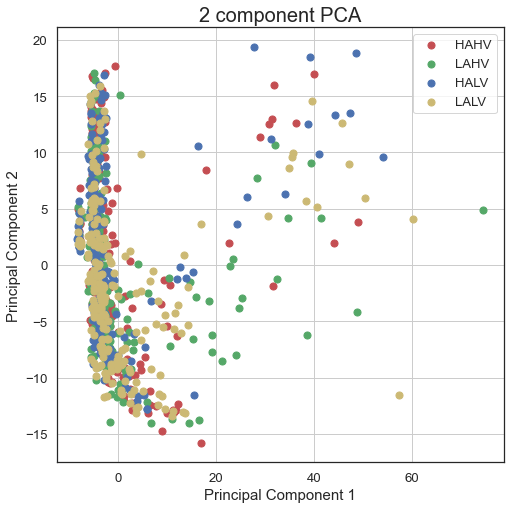

In [244]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['HAHV', 'LAHV', 'HALV', 'LALV']
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = bonus_df['State_name'] == target
    ax.scatter(bonus_df.loc[indicesToKeep, 'pc_0']
               , bonus_df.loc[indicesToKeep, 'pc_1']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Maybe we'll be lucky with arousal or valence?

In [246]:
bonus_df = pd.concat([bonus_dx_new, df_arousal], axis = 1)
bonus_df.head(5)

,pc_0,pc_1,Arousal
0,-7.994597,3.545904,1
1,-7.862166,1.931786,1
2,-7.907023,2.281443,1
3,-7.808095,1.249290,1
4,-8.236244,5.171421,0


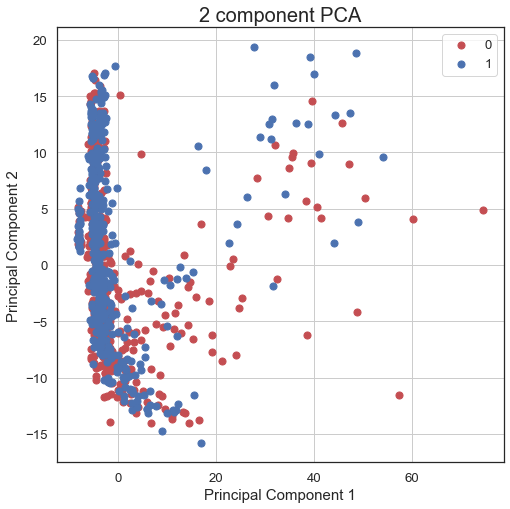

In [247]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = bonus_df['Arousal'] == target
    ax.scatter(bonus_df.loc[indicesToKeep, 'pc_0']
               , bonus_df.loc[indicesToKeep, 'pc_1']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [248]:
bonus_df = pd.concat([bonus_dx_new, df_valence], axis = 1)
bonus_df.head(5)

,pc_0,pc_1,Valence
0,-7.994597,3.545904,1
1,-7.862166,1.931786,1
2,-7.907023,2.281443,1
3,-7.808095,1.249290,0
4,-8.236244,5.171421,1


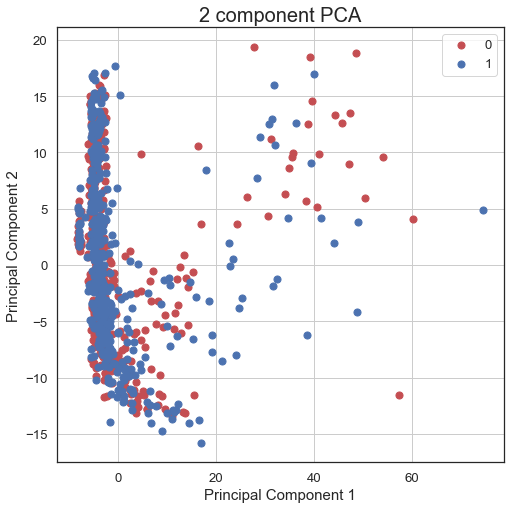

In [249]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = bonus_df['Valence'] == target
    ax.scatter(bonus_df.loc[indicesToKeep, 'pc_0']
               , bonus_df.loc[indicesToKeep, 'pc_1']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

No good results